<a href="https://colab.research.google.com/github/LikeRainDay/colab-demo/blob/main/%E5%9B%BE%E5%83%8F/FixRes%E6%A8%A1%E5%9E%8B%E5%9B%BE%E7%89%87%E7%9B%B8%E4%BC%BC%E5%BA%A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[TOC]

# FixRes 模型简单使用计算向量


[FixRes](https://github.com/facebookresearch/FixRes) 是FaceBook开源的图片分类模型，并刷新了ImageNet的排名。是目前当之无愧的SOTA模型.

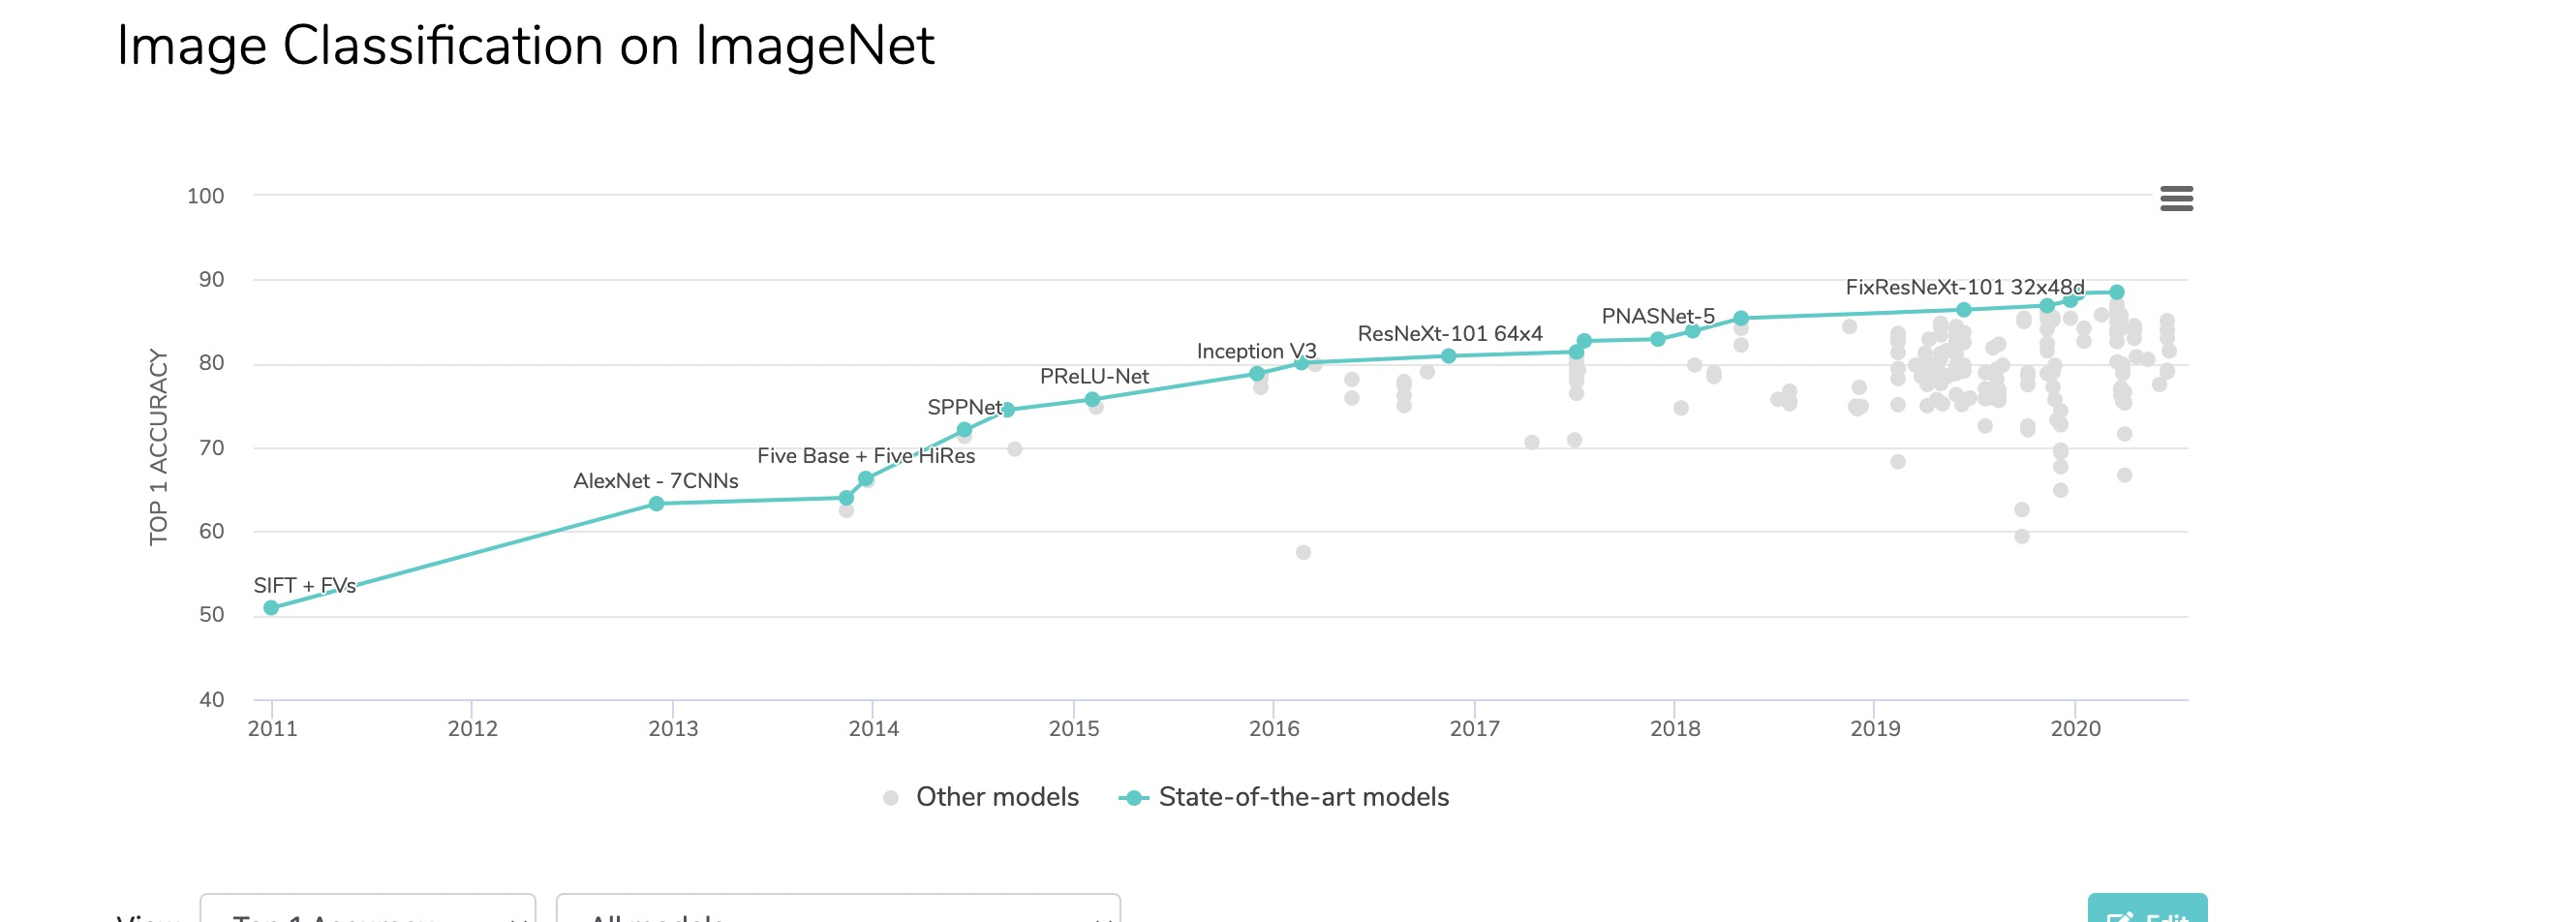

# 查找相似图片

接下来我们进行按照 详细向量计算 来进行查找相似土图片。 
设计思路如下：

1. 准备3组图片 相同类型图片为1组。 总共30张照片
2. 将30张照片过resnet残差模型，产出特征向量并进行记录
3. 追加1张属于3组中任意一组的类型的照片 和 1张不属于任意一组的类型照片。
4. 进行余旋计算相似性，并按照夹角 (1 - |cos(x,y)|)进行倒排
5. 输出相似图片


In [ ]:
# 安装pytroch依赖
!pip install torch  numpy attrs torchvision  Pillow tqdm pillow

In [ ]:
# 对上一章节的内容进行封装
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.hub import load_state_dict_from_url
from torchvision.models.resnet import ResNet, Bottleneck
from torch.autograd import Variable
from numpy import linalg as LA
import requests as req
from io import BytesIO

model_urls = {
    'resnext101_32x8d': 'https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth',
    'resnext101_32x16d': 'https://download.pytorch.org/models/ig_resnext101_32x16-c6f796b0.pth',
    'resnext101_32x32d': 'https://download.pytorch.org/models/ig_resnext101_32x32-e4b90b00.pth',
    'resnext101_32x48d': 'https://download.pytorch.org/models/ig_resnext101_32x48-3e41cc8a.pth',
}


def _resnext(progress=True, **kwargs):
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 48
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    state_dict = load_state_dict_from_url(model_urls['resnext101_32x48d'], progress=progress)
    model.load_state_dict(state_dict)
    model.eval()
    return model


def readImage(src=''):
    response = req.get(src)
    mode = Image.open(BytesIO(response.content))
    # mode.show()
    # mode = Image.open(path)
    # transform1 = transforms.Compose([
    #     transforms.Scale(size),
    #     transforms.CenterCrop((size, size)),
    #     transforms.ToTensor()
    # ])
    # mode = transform1(mode)
    return mode

def convertToTensor(imag, size=256):
    transform1 = transforms.Compose([
        transforms.Scale(size),
        transforms.CenterCrop((size, size)),
        transforms.ToTensor()
    ])
    return transform1(imag)

def showTorchImage(image):
    mode = transforms.ToPILImage()(image)
    plt.imshow(mode)
    plt.show()

def predictVector(model, imageTensor):
    image_num = np.array(imageTensor)
    input_x = torch.from_numpy(image_num).unsqueeze(0)
    result=model(Variable(input_x))
    features=result.data.cpu().numpy()
    norm_feat = features[0]/LA.norm(features[0])
    return norm_feat

In [ ]:
# 准备3组不同类型的图片
dog=[
     "https://ss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=2664799458,3409097076&fm=26&gp=0.jpg",
     "https://ss1.bdstatic.com/70cFvXSh_Q1YnxGkpoWK1HF6hhy/it/u=2070077277,4277386040&fm=15&gp=0.jpg",
     "https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=332787115,2874612314&fm=15&gp=0.jpg",
     "https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=3028859659,1378653865&fm=26&gp=0.jpg",
     "https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2234851085,918168041&fm=15&gp=0.jpg",
     "https://ss1.bdstatic.com/70cFvXSh_Q1YnxGkpoWK1HF6hhy/it/u=1482476338,4087190593&fm=15&gp=0.jpg",
     "https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=10750654,3314326706&fm=15&gp=0.jpg",
     "https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=3598939289,1080472565&fm=15&gp=0.jpg",
     "https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2871489351,4265012730&fm=15&gp=0.jpg",
     "https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2637791067,1452131258&fm=15&gp=0.jpg"
]

car=[
   "https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2008745191,617468549&fm=26&gp=0.jpg",
   "https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=3754614011,4274502543&fm=26&gp=0.jpg",
   "https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=3864937548,543135748&fm=26&gp=0.jpg",
   "https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2893034343,4145148935&fm=26&gp=0.jpg",
   "https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2886379773,82642345&fm=26&gp=0.jpg",
   "https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2266044625,2745462552&fm=26&gp=0.jpg",
   "https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2659913826,2112210319&fm=15&gp=0.jpg",
   "https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2662157767,2973971462&fm=15&gp=0.jpg",
   "https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2860686978,2208749955&fm=15&gp=0.jpg",
   "https://ss1.bdstatic.com/70cFvXSh_Q1YnxGkpoWK1HF6hhy/it/u=1600697761,57272202&fm=15&gp=0.jpg"  
]

cat=[
    "https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=3811776847,2246610098&fm=26&gp=0.jpg",
     "https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=857447233,2411000201&fm=15&gp=0.jpg",
     "https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=3589839242,2213635712&fm=26&gp=0.jpg",
     "https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=3041763884,3364808171&fm=15&gp=0.jpg",
     "https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2716072861,1946522169&fm=15&gp=0.jpg",
     "https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=3274768900,1714394850&fm=26&gp=0.jpg",
     "https://ss1.bdstatic.com/70cFvXSh_Q1YnxGkpoWK1HF6hhy/it/u=2417241772,781053747&fm=15&gp=0.jpg",
     "https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=3113681294,1767932443&fm=26&gp=0.jpg",
     "https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=1364422121,1324118296&fm=26&gp=0.jpg",
     "https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=493147745,1066190905&fm=15&gp=0.jpg"
]

cat_test = "https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=3811776847,2246610098&fm=26&gp=0.jpg"
other_test= "https://dss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=1906469856,4113625838&fm=26&gp=0.jpg"

In [ ]:
# 初始化模型
model = _resnext()

接下来分别将其转化为待输入模型的图片numary维度数据。


In [ ]:
bag = []

def converToDic(url):
    image = readImage(url)
    imageTensor = convertToTensor(image)
    feature =  predictVector(model, imageTensor)
    return feature, imageTensor

def converImageToDic(image):
    imageTensor = convertToTensor(image)
    feature =  predictVector(model, imageTensor)
    return feature, imageTensor

def appendToBag(list):
  for i in list:
    feature, imageTensor = converToDic(i)
    bag.append(
        {
            "type": 1,
            "feature": feature,
            "tensor": imageTensor
        }
    )

In [ ]:
# 狗的图片转化
appendToBag(dog)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [ ]:
# 车的图片转化
appendToBag(car)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [ ]:
# 猫的图片转化
appendToBag(cat)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


对相同类别和非类别进行查询特征内容。

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


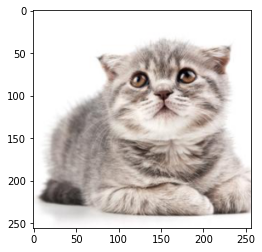

In [ ]:
# 相似类型照片
fe,tensor = converToDic(cat_test)

showTorchImage(tensor)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


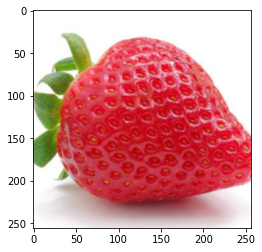

In [ ]:
# 非相似类型照片
or_fe,or_tensor = converToDic(other_test)

showTorchImage(or_tensor)

In [ ]:
# 进行向量计算相似度

def cos_sim(vector_a, vector_b):
    """
    计算两个向量之间的余弦相似度
    :param vector_a: 向量 a 
    :param vector_b: 向量 b
    :return: sim
    """
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

def cos_fun(feature):
  for index in bag:
    sim = cos_sim(feature, index["feature"])
    index["sim"] = sim

1.0000000596046448


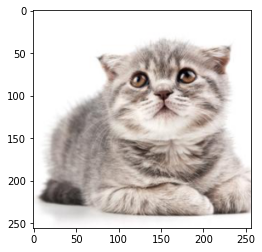

0.9196913540363312


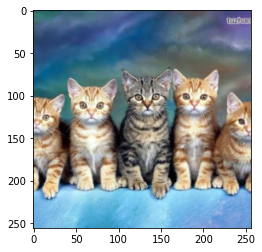

0.8956879079341888


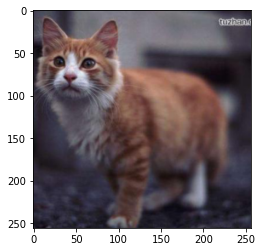

0.8873677551746368


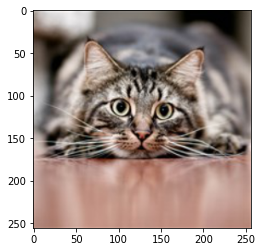

0.8758547902107239


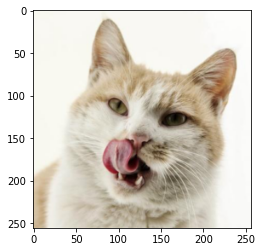

0.8728285578284929


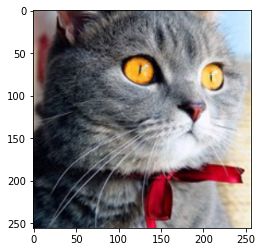

In [ ]:
# cos_fun(or_fe)

tmp = bag

cos_fun(fe)
# 按照相关性进行排序

bag = sorted(bag, key=lambda x:x['sim'],reverse= True)

for i in bag[0:6]:
  print(i["sim"])
  showTorchImage(i["tensor"])


将其封装成一个方法，根据上传的图片查询相似的图片（从我们预先定义好的30个待选数据集中）

可是使用测试中的地址图片进行。


In [ ]:
from google.colab import files

content_img = files.upload()


Saving u=1926888889,775995879&fm=26&gp=0.jpg to u=1926888889,775995879&fm=26&gp=0 (1).jpg


In [ ]:
import os

CONTENT_IMAGE_FN = list(content_img)[0]
CONTENT_IMAGE_FN_temp = CONTENT_IMAGE_FN.strip().replace(" ", "_")

if CONTENT_IMAGE_FN != CONTENT_IMAGE_FN_temp:
  os.rename(CONTENT_IMAGE_FN, CONTENT_IMAGE_FN_temp)
  CONTENT_IMAGE_FN = CONTENT_IMAGE_FN_temp
  
print("Content image filename :", CONTENT_IMAGE_FN)

Content image filename : u=1926888889,775995879&fm=26&gp=0.jpg


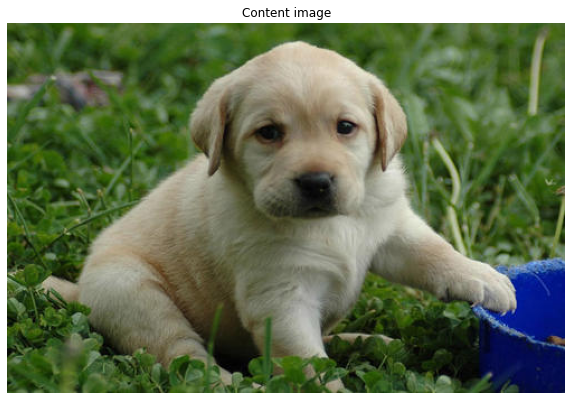

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
img = plt.imread(CONTENT_IMAGE_FN)
plt.axis('off')
plt.title('Content image')
plt.imshow(img)

In [ ]:
# 进行对图片内容的读取 并进行选择出相似照片
def getSim():
  fe,tensor = converImageToDic(Image.open(CONTENT_IMAGE_FN))
  cos_fun(fe)
  re = sorted(tmp, key=lambda x:x['sim'],reverse= True)
  for i in re[0:6]:
    print(i["sim"])
    showTorchImage(i["tensor"])

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


0.9399483168094347


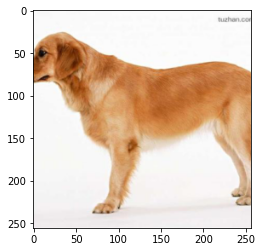

0.9303691900216567


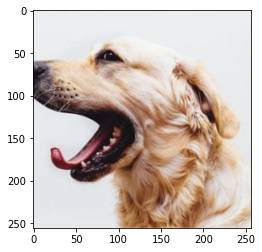

0.809233158826828


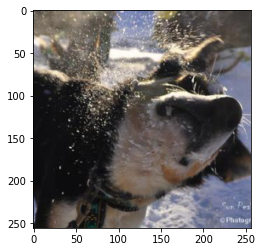

0.7951366183243167


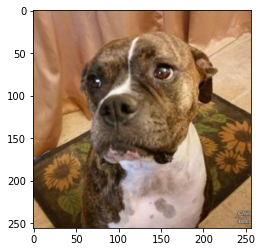

0.7810798287391663


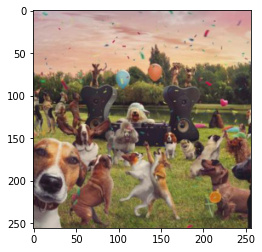

0.7726249992847443


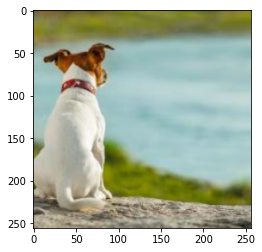

In [ ]:

getSim()